# 📚 Imports
---

In [1]:
import pandas as pd
import re
import string
import collections
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 📖 Data 
---

In [2]:
df_train = pd.read_csv('/kaggle/input/amazon-reviews/train.csv')
df_test = pd.read_csv('/kaggle/input/amazon-reviews/test.csv')

In [3]:
df_train.head()

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

### Insert columns

In [5]:
df_train.columns = ['label', 'title', 'text']
df_train.head()

,label,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [6]:
df_test.columns = ['label', 'title', 'text']
df_test.head()

,label,title,text
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


### Using only 50,000 texts for training and 5,000 for validation (anything I raise)

In [7]:
df_train = df_train.head(100000)
df_test = df_test.head(10000)

In [8]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

2    51267
1    48733
Name: label, dtype: int64
2    5124
1    4876
Name: label, dtype: int64


### I'll join the title with the text because I think the title is shorter, people tend to put keywords in it

In [9]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

### I will change the 'label' column values to 1 -> 0 and 2 -> 1

In [10]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [11]:
df_train.head()

,label,text
0,1,I'm reading a lot of reviews saying that this ...
1,1,This soundtrack is my favorite music of all ti...
2,1,I truly like this soundtrack and I enjoy video...
3,1,"If you've played the game, you know how divine..."
4,1,I am quite sure any of you actually taking the...


### Now the data is ready for cleaning.

# ♻️ Data Cleaning
---

## Function to remove unwanted characters

In [12]:
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    # Analyzing the most used words below, i chose to exclude these because there are too many and are unnecessary
    text = re.sub('book|one', '', text)
    # Convert to lower case
    text = text.lower()
    # remove scores
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Applying the function
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

## Function to remove stop words

In [13]:
def remove_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(texto.lower())
    return " ".join([token for token in tokens if token not in stop_words])

# Applying the function
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

## Function to normalize the words

In [14]:
def normalize_text(text):
    stemmer = SnowballStemmer("english")
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)
    return ' '.join(normalized_text)
    
# Applying the function
df_train['text'] = df_train['text'].apply(normalize_text)
df_test['text'] = df_test['text'].apply(normalize_text)

# 📊 Top 10 most used words
---

## Train data

Text(0, 0.5, 'Frequency')

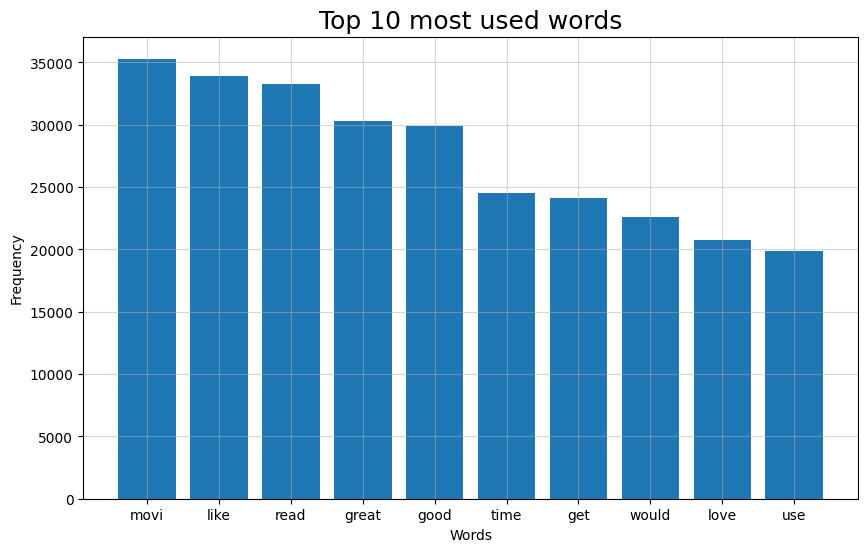

In [15]:
words = []
for text in df_train['text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)

# Title and labels
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

## Test data

Text(0, 0.5, 'Frequency')

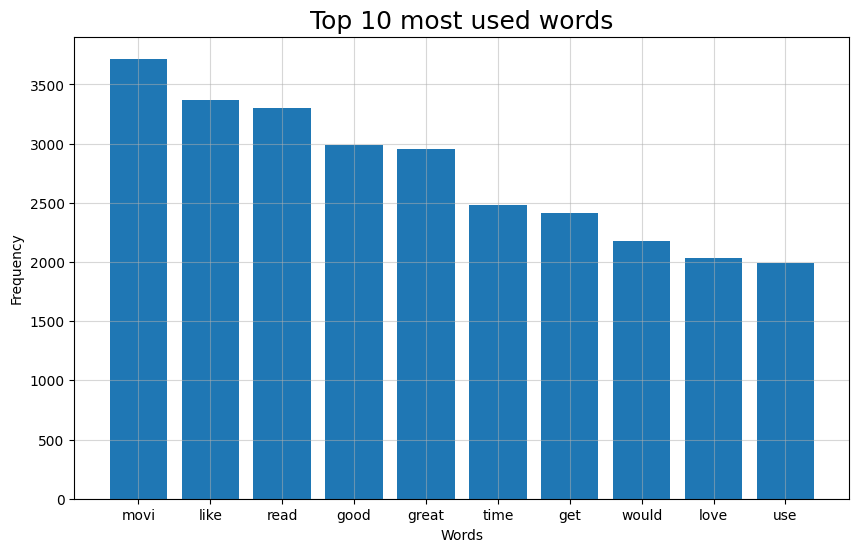

In [16]:
words = []
for text in df_test['text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)
# Title and labels
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

 # 🧬 Text processing
 ---

In [17]:
# Maximum number of words to be considered in the vocabulary
max_words = 10000 
# Maximum number of tokens in a sequence
max_len = 200 
# Tokenizer
tokenizer = Tokenizer(num_words = max_words) 
# Snap tokenizer to text data
tokenizer.fit_on_texts(df_train['text']) 
# Converts texts into strings of numbers
sequences_train = tokenizer.texts_to_sequences(df_train['text']) 
sequences_val = tokenizer.texts_to_sequences(df_test['text']) 
# Mapping words to indexes
word_index = tokenizer.word_index 

In [18]:
# Sequence padding
data_train = pad_sequences(sequences_train, maxlen = max_len)
data_val = pad_sequences(sequences_val, maxlen = max_len)

# 🤖 Model
---

In [19]:
# Create the model
model = tf.keras.Sequential()
model.add(Embedding(max_words, 16, input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Checking summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit model
history = model.fit(data_train, df_train['label'], epochs = 15, batch_size = 64, validation_data = (data_val, df_test['label']))

Epoch 1/15
1563/1563 [==============================] - 56s 33ms/step - loss: 0.6025 - accuracy: 0.7354 - val_loss: 0.4749 - val_accuracy: 0.8455
Epoch 2/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.4007 - accuracy: 0.8593 - val_loss: 0.3563 - val_accuracy: 0.8659
Epoch 3/15
1563/1563 [==============================] - 9s 6ms/step - loss: 0.3266 - accuracy: 0.8757 - val_loss: 0.3200 - val_accuracy: 0.8729
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2976 - accuracy: 0.8835 - val_loss: 0.3066 - val_accuracy: 0.8759
Epoch 5/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2823 - accuracy: 0.8887 - val_loss: 0.3012 - val_accuracy: 0.8769
Epoch 6/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2730 - accuracy: 0.8924 - val_loss: 0.2995 - val_accuracy: 0.8776
Epoch 7/15
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2660 - accuracy: 0.8952 - val_loss: 0.2978 - val_accura

# Evaluate the model
---

## Accuracy

In [21]:
loss, accuracy = model.evaluate(data_val, df_test['label'], verbose = 0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 88.010001


## Loss graph

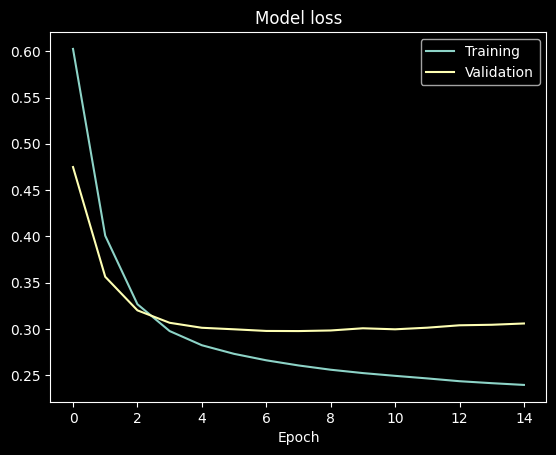

In [22]:
# Loss graph
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()

## Accuracy graph

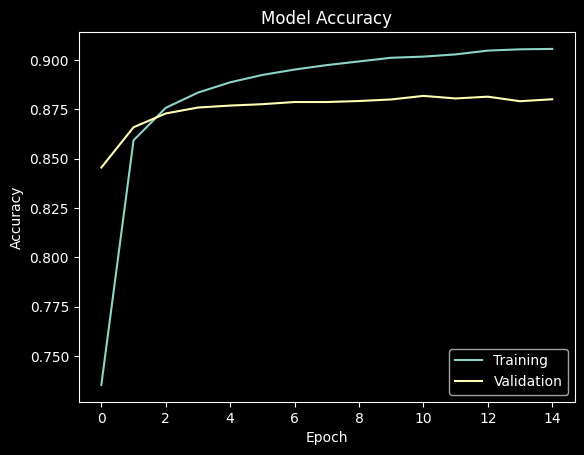

In [23]:
# Accuracy graph
plt.style.use('dark_background')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()

# 🏁 Thank you! Feel free to criticize! 🏁¶